## SVM

Using MPS device
Fold 1/3


Epoch 1/100:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 100/100: 100%|██████████| 1250/1250 [00:02<00:00, 498.82it/s]


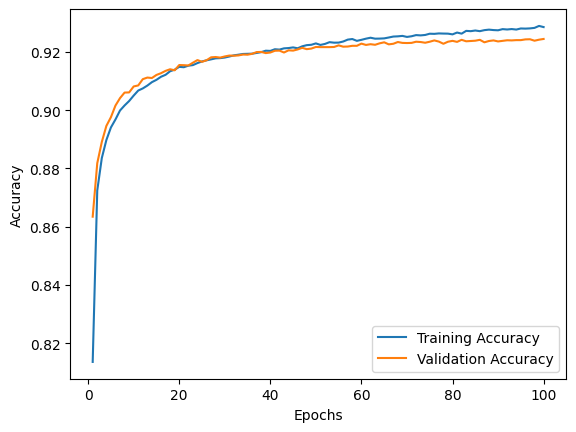

Fold accuracy: 0.92445
Fold 2/3


Epoch 100/100: 100%|██████████| 1250/1250 [00:02<00:00, 556.41it/s]


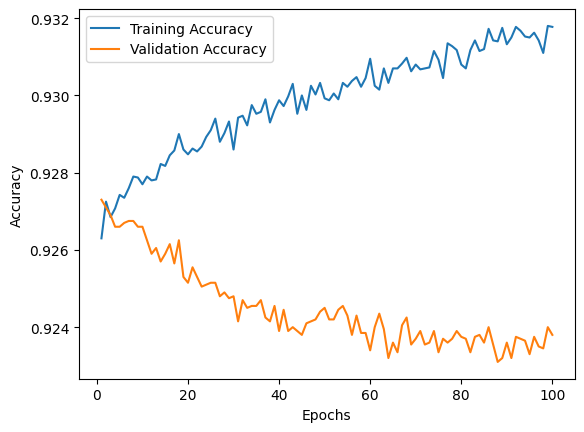

Fold accuracy: 0.9238
Fold 3/3


Epoch 100/100: 100%|██████████| 1250/1250 [00:02<00:00, 487.22it/s]


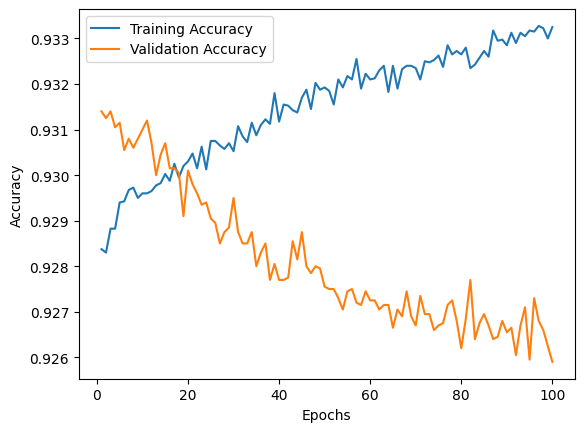

Fold accuracy: 0.9259
SVM cross-validation scores: [0.92445, 0.9238, 0.9259]
Average accuracy: 0.9247166514396667


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from sklearn.model_selection import KFold
import numpy as np

n_epochs = 100

# Assuming you have your data loaded as x_train_svm and y_train_svm (NumPy arrays)

# Convert data to PyTorch tensors
x_train_tensor = torch.from_numpy(x_train_svm).float()
y_train_tensor = torch.from_numpy(y_train_svm).long()  # LongTensor for class labels

# Check for MPS device
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
else:
    device = torch.device("cpu")
    print("MPS device not found, using CPU")

# Define your SVM model in PyTorch
class SVM(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SVM, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

# Instantiate the model
input_size = x_train_svm.shape[1]  # Number of features
num_classes = len(np.unique(y_train_svm))  # Number of classes
svm_model = SVM(input_size, num_classes)

# Move model to the MPS device
svm_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use CrossEntropyLoss for multi-class classification
optimizer = optim.SGD(svm_model.parameters(), lr=0.01)

# Perform k-fold cross-validation (e.g., k=3)
k = 3
kf = KFold(n_splits=k, shuffle=True, random_state=42)  # Shuffle data for better generalization
cross_svm_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(x_train_tensor)):
    print(f'Fold {fold + 1}/{k}')

    # Create data loaders for training and validation sets
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)
    train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), batch_size=32, sampler=train_sampler)
    val_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), batch_size=32, sampler=val_sampler)

    # Training loop
    train_accuracies = []
    val_accuracies = []

    for epoch in range(n_epochs):
        svm_model.train()
        correct_train = 0
        total_train = 0
        for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{n_epochs}'):
            # Move data and target to the MPS device
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = svm_model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        svm_model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for data, target in val_loader:
                # Move data and target to the MPS device
                data = data.to(device)
                target = target.to(device)
                output = svm_model(data)
                _, predicted = torch.max(output.data, 1)
                total_val += target.size(0)
                correct_val += (predicted == target).sum().item()

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

    plt.plot(range(1, n_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, n_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Validation loop
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            # Move data and target to the MPS device
            data = data.to(device)
            target = target.to(device)
            output = svm_model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = correct / total
    cross_svm_scores.append(accuracy)
    print(f'Fold accuracy: {accuracy}')

# Print average accuracy across all folds
print(f'SVM cross-validation scores: {cross_svm_scores}')
print(f'Average accuracy: {torch.mean(torch.tensor(cross_svm_scores))}')